In [794]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet, RidgeCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.ensemble import RandomForestRegressor
import re
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
from tqdm import tqdm


In [795]:
# Import the data

demographics = pd.read_csv('new_Data/demographics_4_Guilia.csv')

ROIs = pd.read_csv("new_Data/dka_HCP_test.csv")
ROIs = ROIs["name"]
columns = [ROI + "_" + str(j/2) for ROI in ROIs for j in range(0, 300)]

psds = pd.read_csv('new_Data/PSD_Rest.csv', header=None)
psds.columns = columns

In [796]:
psds.head()

,bankssts L_0.0,bankssts L_0.5,bankssts L_1.0,bankssts L_1.5,bankssts L_2.0,bankssts L_2.5,bankssts L_3.0,bankssts L_3.5,bankssts L_4.0,bankssts L_4.5,...,transversetemporal R_145.0,transversetemporal R_145.5,transversetemporal R_146.0,transversetemporal R_146.5,transversetemporal R_147.0,transversetemporal R_147.5,transversetemporal R_148.0,transversetemporal R_148.5,transversetemporal R_149.0,transversetemporal R_149.5
0,1.166112,7.310916,5.172159,2.908277,1.780837,1.194868,1.090405,1.041240,0.966275,0.866052,...,0.013225,0.014056,0.012924,0.011307,0.011478,0.011786,0.010631,0.009448,0.006987,0.003150
1,1.726824,11.262225,8.457395,5.106392,3.424434,2.753602,2.462952,2.272813,2.133286,1.975146,...,0.019069,0.017784,0.018208,0.019443,0.018315,0.017127,0.016271,0.015401,0.010584,0.007986
2,1.283245,8.512901,5.622469,3.662541,2.693076,2.195658,1.881473,1.665905,1.550854,1.544194,...,0.011910,0.012364,0.012478,0.012050,0.011816,0.012486,0.011117,0.009719,0.007808,0.003464
3,0.779096,5.631812,4.190357,2.781331,2.186175,2.060094,1.706472,1.454541,1.415902,1.377155,...,0.007378,0.007126,0.007329,0.007236,0.006535,0.006806,0.006740,0.006133,0.004261,0.002017
4,0.843786,5.370334,4.005501,2.143103,1.772349,1.449305,1.291349,1.441181,1.354650,1.279961,...,0.005973,0.006015,0.006312,0.005653,0.005771,0.005979,0.005880,0.005315,0.003970,0.001791


In [797]:
demographics.head()

,Unnamed: 0,CCID,homeint_sex,homeint_duration,homeint_mmse_i,homeint_handedness,homeint_quitquestion,homeint_v1,homeint_v19,homeint_v20,...,additional_attention_orientation,additional_memory,additional_fluencies,additional_language,additional_visuospatial,additional_acer,Catell_score,age,Group,Sex
0,2,sub_CC110033,M,63.0,30.0,90.0,NaN,1.0,1.0,NaN,...,18.0,24.0,13.0,26.0,16.0,97.0,NaN,24.17,young adult,MALE
1,3,sub_CC110037,M,559.0,30.0,89.0,NaN,1.0,1.0,NaN,...,18.0,26.0,14.0,26.0,16.0,100.0,30.0,18.75,young adult,MALE
2,5,sub_CC110045,F,132.0,30.0,100.0,NaN,2.0,1.0,NaN,...,18.0,26.0,14.0,26.0,16.0,100.0,41.0,24.50,young adult,FEMALE
3,6,sub_CC110056,F,80.0,29.0,100.0,NaN,2.0,1.0,NaN,...,17.0,26.0,12.0,26.0,14.0,95.0,24.0,22.67,young adult,FEMALE
4,10,sub_CC110069,F,-184.0,28.0,-58.0,NaN,2.0,1.0,NaN,...,16.0,26.0,14.0,23.0,15.0,94.0,41.0,28.67,young adult,FEMALE


In [798]:
# Apply log to the PSDs

psds = np.log(psds)

# 1. Predict global scores from every feature

In [799]:
# Remove old people (ie age > 45)

mask = demographics["Group"] == "young adult"
demographics = demographics[mask]
psds = psds[mask]

In [800]:
# To predict
col_to_predict = "Catell_score"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = psds.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [801]:
# Standardization of the input
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [790]:
# # Standardization of the output

# scaler_output = StandardScaler()

# y_train = scaler_output.fit_transform(y_train.reshape(-1, 1))
# y_test = scaler_output.transform(y_test.reshape(-1, 1))

In [791]:
# PCA
pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [802]:
# Linear Rigde Regression
lr = Ridge(alpha = 10)
lr.fit(X_train, y_train)

lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9999846154493947, -0.36311621064312627)

MSE training :  0.0002894231934624879
MSE test :  24.54122042015703
Correlation test :  PearsonRResult(statistic=0.12405382873315013, pvalue=0.3408266323166719)


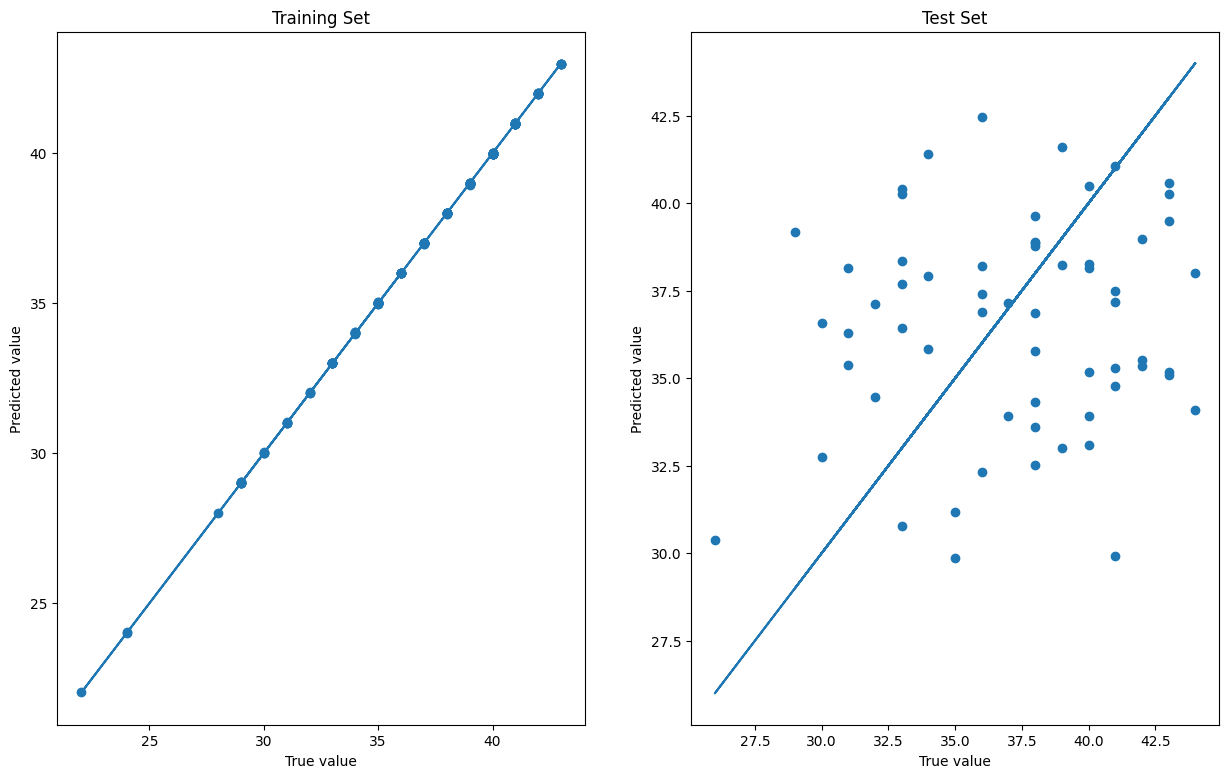

In [803]:
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred = lr.predict(X_train)
# y_train, y_train_pred = scaler_output.inverse_transform(y_train), scaler_output.inverse_transform(y_train_pred)
print("MSE training : ", mean_squared_error(y_train, y_train_pred))

ax0.scatter(x=y_train, y=y_train_pred)
ax0.plot(y_train, y_train)
ax0.set_title("Training Set")
ax0.set_xlabel("True value")
ax0.set_ylabel("Predicted value")

y_test_pred = lr.predict(X_test)
# y_test, y_test_pred = scaler_output.inverse_transform(y_test), scaler_output.inverse_transform(y_test_pred)
print("MSE test : ", mean_squared_error(y_test, y_test_pred))

ax1.scatter(x=y_test, y=y_test_pred)
ax1.plot(y_test, y_test)
ax1.set_title("Test Set")
ax1.set_xlabel("True value")
ax1.set_ylabel("Predicted value")

print("Correlation test : ", pearsonr(y_test, y_test_pred))


In [680]:
def train_and_predict(X, y, test_split = 0.2, nb_components_pca = 10, standard_input = True, standard_output = False, model = Ridge(), plot = True) :

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split)

    if standard_input :
        # Standardization of the input
        scaler = StandardScaler()

        X_train = scaler.fit_transform(X_train)
        X_test = scaler.fit_transform(X_test)

    if standard_output :
        # Standardization of the output

        scaler_output = StandardScaler()

        y_train = scaler_output.fit_transform(y_train.reshape(-1, 1))
        y_test = scaler_output.transform(y_test.reshape(-1, 1))

        y_train = y_train.reshape(-1,)
        y_test = y_test.reshape(-1,)

    if nb_components_pca :
        # PCA
        pca = PCA(n_components=50)
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)

    # Linear Rigde Regression
    lr = model
    lr.fit(X_train, y_train)

    y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)

    # Plot results
    if plot :
        _, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

        print("MSE training : ", mean_squared_error(y_train, y_train_pred))

        ax0.scatter(x=y_train, y=y_train_pred)
        ax0.plot(y_train, y_train)
        ax0.set_title("Training Set")
        ax0.set_xlabel("True value")
        ax0.set_ylabel("Predicted value")

        y_test_pred = lr.predict(X_test)
        print("MSE test : ", mean_squared_error(y_test, y_test_pred))

        ax1.scatter(x=y_test, y=y_test_pred)
        ax1.plot(y_test, y_test)
        ax1.set_title("Test Set")
        ax1.set_xlabel("True value")
        ax1.set_ylabel("Predicted value")

        plt.show()
    
    return pearsonr(y_test, y_test_pred)[0]

In [775]:
# Good result for now on:

test_split = 0.2
nb_components_pca = None
standard_input = True
standard_output = False
model = Ridge(alpha=10.0)
plot = False

corr = []

for _ in tqdm(range(100), total = 100):
    correlation = train_and_predict(X, y, test_split, nb_components_pca, standard_input, standard_output, model, plot)
    corr.append(correlation)

100%|██████████| 100/100 [00:54<00:00,  1.83it/s]


In [776]:
np.mean(corr), np.std(corr)

(0.4594211085091735, 0.06415138051877602)

# Try to keep only some frequencies

In [727]:
cols_to_keep = [c for c in psds.columns if  float(re.search("[0-9]+\.[0-9]*", c).group(0)) >= 1.0 and float(re.search("[0-9]+\.[0-9]*", c).group(0)) < 50.0]

In [744]:
# To predict
col_to_predict = "age"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = psds[cols_to_keep]
X = X.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)


test_split = 0.2
nb_components_pca = None
standard_input = True
standard_output = False
model = Ridge(alpha=10.0)
plot = False
corr = []

for _ in tqdm(range(300), total=300):
    correlation = train_and_predict(X, y, test_split, nb_components_pca, standard_input, standard_output, model, plot)
    corr.append(correlation)


100%|██████████| 300/300 [02:32<00:00,  1.96it/s]


0.6398250503058581 0.08818663366946393


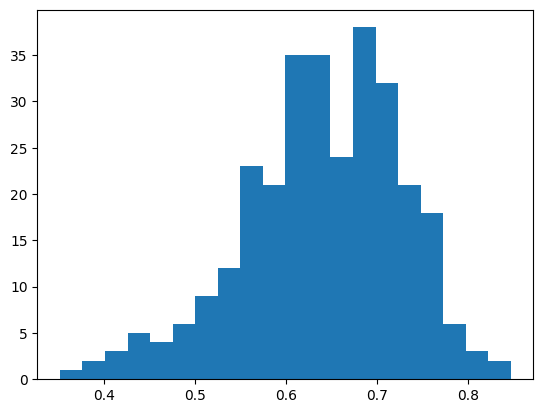

In [745]:
print(np.mean(corr), np.std(corr))
plt.hist(corr, bins = 20)
plt.show()

# With DL

In [411]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, Input, Dropout
from tensorflow.keras import Model

Epoch 1/20
8/8 [==============================] - 1s 104ms/step - loss: 2.1168 - mae: 2.1168 - val_loss: 0.8172 - val_mae: 0.8172
Epoch 2/20
8/8 [==============================] - 0s 36ms/step - loss: 1.2351 - mae: 1.2351 - val_loss: 0.7511 - val_mae: 0.7511
Epoch 3/20
8/8 [==============================] - 0s 36ms/step - loss: 0.8922 - mae: 0.8922 - val_loss: 0.5598 - val_mae: 0.5598
Epoch 4/20
8/8 [==============================] - 0s 31ms/step - loss: 0.7315 - mae: 0.7315 - val_loss: 0.4608 - val_mae: 0.4608
Epoch 5/20
8/8 [==============================] - 0s 26ms/step - loss: 0.5316 - mae: 0.5316 - val_loss: 0.3151 - val_mae: 0.3151
Epoch 6/20
8/8 [==============================] - 0s 34ms/step - loss: 0.4882 - mae: 0.4882 - val_loss: 0.2781 - val_mae: 0.2781
Epoch 7/20
8/8 [==============================] - 0s 39ms/step - loss: 0.4568 - mae: 0.4568 - val_loss: 0.3280 - val_mae: 0.3280
Epoch 8/20
8/8 [==============================] - 0s 27ms/step - loss: 0.4349 - mae: 0.4349 - va

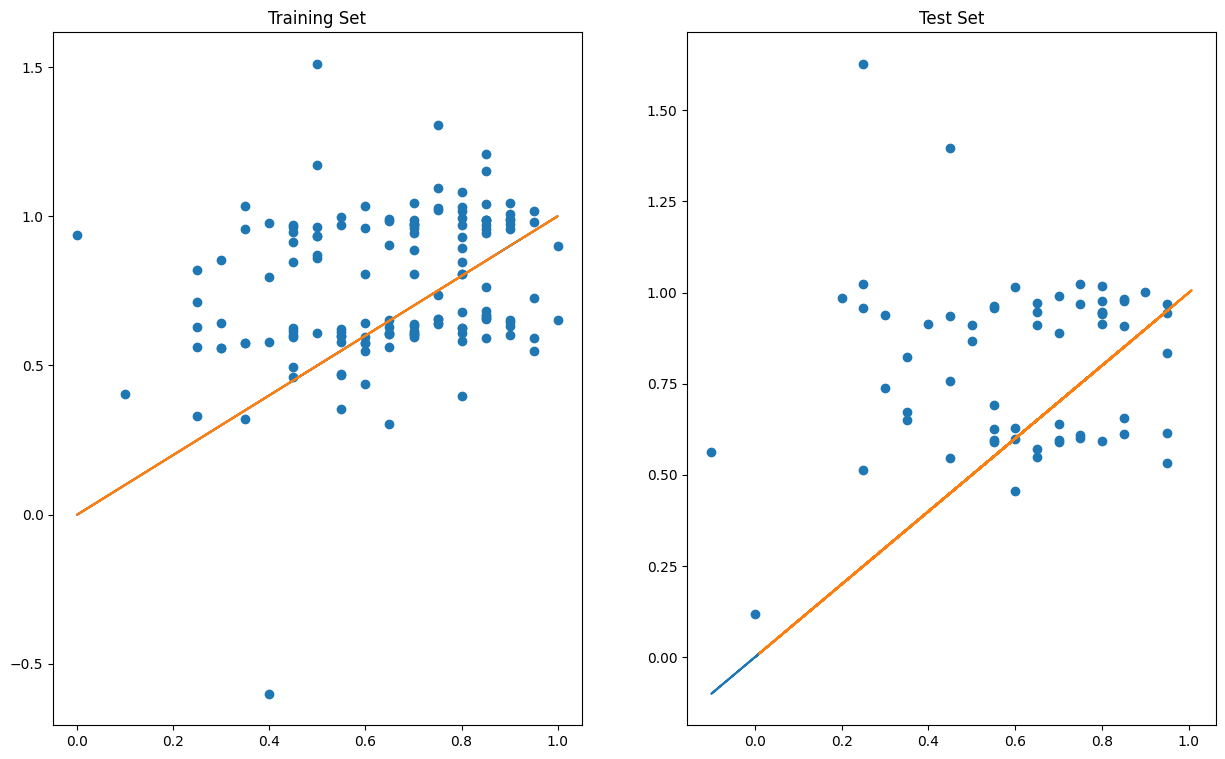

In [539]:
# To predict
col_to_predict = ["Catell_score", "age"]
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = psds.copy()
X = X.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Standardization of the input
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


scaler_output = MinMaxScaler()

y_train = scaler_output.fit_transform(y_train)
y_test = scaler_output.transform(y_test)

# Create model
input = Input(shape=(X.shape[1]))
hidden = Dense(1024, activation = "sigmoid")(input)
hidden = Dropout(0.2)(hidden)
hidden = BatchNormalization()(hidden)
hidden = Dense(512, activation = "sigmoid")(hidden)
hidden = Dropout(0.2)(hidden)
hidden = BatchNormalization()(hidden)
output = Dense(2)(hidden)

model = Model(inputs = input, outputs = output)

model.compile(loss = "mae", optimizer="adam", metrics=["mae"])

#Fit model
model.fit(X_train, y_train, epochs = 20, validation_split = 0.2, batch_size=16)

# Plot results
_, (ax0, ax1) = plt.subplots(figsize = (15, 9), ncols=2)

y_train_pred = model.predict(X_train)
print("MSE training : ", mean_squared_error(y_train, y_train_pred))

ax0.scatter(x=y_train[:,0], y=y_train_pred[:,0])
ax0.plot(y_train, y_train)
ax0.set_title("Training Set")

y_test_pred = model.predict(X_test)
print("MSE test : ", mean_squared_error(y_test, y_test_pred))

ax1.scatter(x=y_test[:,0], y=y_test_pred[:,0])
ax1.plot(y_test, y_test)
ax1.set_title("Test Set")

plt.show()

# New features processing

## Average per band

In [805]:
BROADBAND = (0.0, 150.0)
DELTA = (0.0, 4.0)
THETA = (4.0, 8.0)
ALPHA = (8.0, 13.0)
BETA = (13.0, 30.0)
GAMMA = (30.0, 50.0)
HIGH_GAMMA = (50.0, 150.0)

bands = [DELTA, THETA, ALPHA, BETA, GAMMA, HIGH_GAMMA]

In [808]:
avg_psds = np.zeros((psds.shape[0],6))

for k, band in enumerate(bands):
    columns_band_freq = [c for c in psds.columns if float(re.search("[0-9]+\.[0-9]*", c).group(0)) >= band[0] and float(re.search("[0-9]+\.[0-9]*", c).group(0)) < band[1]]
    psds_band = psds[columns_band_freq]
    avg_psds[:, k] = np.mean(psds_band, axis=1)

In [810]:
avg_psds = pd.DataFrame(avg_psds, columns = ["Delta", "Theta", "Alpha", "Beta", "Gamma", "High Gamma"]) 

,Delta,Theta,Alpha,Beta,Gamma,High Gamma
0,1.273034,0.128179,0.178182,-0.498392,-2.028279,-2.708362
1,1.237832,0.319975,0.002091,-0.996203,-2.101035,-2.820252
2,1.278823,0.538073,0.230532,-0.872427,-2.056754,-2.827937
3,1.227882,0.543446,-0.005334,-0.697368,-2.467764,-3.429071
4,0.979032,0.532299,0.716635,-0.373444,-2.125706,-3.133347
...,...,...,...,...,...,...
199,0.656525,0.210330,0.825338,-0.268797,-2.255101,-3.275790
200,0.960362,0.381886,0.642489,-0.376925,-1.920129,-2.841085
201,0.701472,0.379353,0.759616,-0.328697,-2.163358,-3.099837
202,0.770909,-0.027024,0.656065,-0.672023,-2.045393,-2.677238


In [812]:
# To predict
col_to_predict = "age"
y = demographics[col_to_predict]
y = y.to_numpy()

# Features
X = psds[cols_to_keep]
X = X.to_numpy()

# Remove Nan Values
index = np.where(np.isnan(y) == True)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)

# Remove the outliers, ex here one with a score of 0
index = np.where(y == 0)[0]
X = np.delete(X, index, axis=0)
y = np.delete(y, index, axis=0)


test_split = 0.2
nb_components_pca = None
standard_input = True
standard_output = False
model = Ridge(alpha=10.0)
plot = False

for _ in tqdm(range(20), total=20):
    correlation = train_and_predict(X, y, test_split, nb_components_pca, standard_input, standard_output, model, plot)
    corr.append(correlation)

corr

100%|██████████| 20/20 [00:10<00:00,  1.95it/s]

[0.49489102113153904, 0.4487057531478191, 0.3975714087175042, 0.4882749110065162, 0.49927828141024994, 0.3206154650446201, 0.30399680884088764, 0.4547903506264567, 0.3710154599160982, 0.5050790478493816, 0.4197343211598167, 0.3937651458490574, 0.4716492494836046, 0.5750892179433535, 0.49293104954769834, 0.4915331098163459, 0.37902534959123235, 0.4169010877528398, 0.41520301208651117, 0.5355496346908656, 0.4545949280819102, 0.5504641086350903, 0.4199170158559978, 0.38320119753466536, 0.42331221566502175, 0.41249920179953553, 0.5116966862200681, 0.4102956812228951, 0.5217685706899042, 0.4647536159415773, 0.47819784882872884, 0.43975753652382826, 0.47412663824407714, 0.4836108927313975, 0.42022243380586377, 0.34812802959095335, 0.4772996033117253, 0.48551391306936725, 0.3738469652466682, 0.431817341576918, 0.5422666948726108, 0.5032879717813373, 0.4026342140031062, 0.3149829176320256, 0.6047968138794044, 0.4203603803820387, 0.5051755166082199, 0.44021558883954226, 0.43110123195461986, 0.4

In [813]:
corr

[0.49489102113153904,
 0.4487057531478191,
 0.3975714087175042,
 0.4882749110065162,
 0.49927828141024994,
 0.3206154650446201,
 0.30399680884088764,
 0.4547903506264567,
 0.3710154599160982,
 0.5050790478493816,
 0.4197343211598167,
 0.3937651458490574,
 0.4716492494836046,
 0.5750892179433535,
 0.49293104954769834,
 0.4915331098163459,
 0.37902534959123235,
 0.4169010877528398,
 0.41520301208651117,
 0.5355496346908656,
 0.4545949280819102,
 0.5504641086350903,
 0.4199170158559978,
 0.38320119753466536,
 0.42331221566502175,
 0.41249920179953553,
 0.5116966862200681,
 0.4102956812228951,
 0.5217685706899042,
 0.4647536159415773,
 0.47819784882872884,
 0.43975753652382826,
 0.47412663824407714,
 0.4836108927313975,
 0.42022243380586377,
 0.34812802959095335,
 0.4772996033117253,
 0.48551391306936725,
 0.3738469652466682,
 0.431817341576918,
 0.5422666948726108,
 0.5032879717813373,
 0.4026342140031062,
 0.3149829176320256,
 0.6047968138794044,
 0.4203603803820387,
 0.5051755166082199,